In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/home/vantuan_ngo/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
import importlib
import utils
importlib.reload(utils)
from utils import *
import AD
importlib.reload(AD)
from AD import *
import utils_dataset
importlib.reload(utils_dataset)
from utils_dataset import *

In [3]:
# latent_dim = 2^10
# ae = AE(input_channels=2, latent_dim=latent_dim, img_height=300, img_width=14).to(device)
# latent_dim = 512
# ae = AE(latent_dim=latent_dim).to(device)
ae = AE().to(device)
# print(ae.summary())

Calculated feature map: [64, 38, 14], feature_dim=34048


Output shape verified: torch.Size([2, 300, 14])


In [4]:
import os
import pandas as pd
TRAIN_DF_FILE_PATH = os.path.join("../datasets/FccIQ/synthetic/train_df.csv")
print("TRAIN_DF_FILE_PATH: ", TRAIN_DF_FILE_PATH)
train_df = pd.read_csv(TRAIN_DF_FILE_PATH)
print(f'train_df.shape: {train_df.shape}')
print(train_df.head())

# train_df = train_df[train_df["SNR"] <= 20]
# train_df = train_df.sample(n=10, random_state=42)

trains = load_train_dataset(train_df)
print(f'trains.shape: {trains.shape}')

TRAIN_DF_FILE_PATH:  ../datasets/FccIQ/synthetic/train_df.csv
train_df.shape: (5261, 7)
   SNR  SIR  MCS  FRQ  Slot  \
0    2   -1    1   -1     1   
1    2   -1    1   -1     2   
2    2   -1    1   -1     3   
3    2   -1    1   -1     5   
4    2   -1    1   -1     7   

                                           file_path  ground_truth_file_path  
0  /home/vantuan_ngo/anomalib-example/FccIQ/../da...                     NaN  
1  /home/vantuan_ngo/anomalib-example/FccIQ/../da...                     NaN  
2  /home/vantuan_ngo/anomalib-example/FccIQ/../da...                     NaN  
3  /home/vantuan_ngo/anomalib-example/FccIQ/../da...                     NaN  
4  /home/vantuan_ngo/anomalib-example/FccIQ/../da...                     NaN  
trains.shape: torch.Size([5261, 2, 300, 14])


In [5]:
batch_size = 128
train_loader = DataLoader(trains, batch_size=batch_size, shuffle=True)
i, data = next(enumerate(train_loader))
print(i)
print(data.shape)

0
torch.Size([128, 2, 300, 14])


In [ ]:
epochs = 1000
beta = 1
train_AE(ae, train_loader, epochs=epochs, learning_rate=3e-4, beta=beta, device=device)
# train_autoencoder(ae, train_loader, epochs=epochs)
# train_autoencoder(ae, train_loader, num_epochs=epochs, lr=1e-3, device=device)

Epoch 1/1000, Loss: 5398.802441
Epoch 2/1000, Loss: 4759.827031
Epoch 3/1000, Loss: 4647.116823
Epoch 4/1000, Loss: 4592.995215
Epoch 5/1000, Loss: 4561.016047
Epoch 6/1000, Loss: 4543.563450
Epoch 7/1000, Loss: 4531.503110
Epoch 8/1000, Loss: 4522.009348
Epoch 9/1000, Loss: 4511.595721
Epoch 10/1000, Loss: 4502.481777
Epoch 11/1000, Loss: 4494.320925
Epoch 12/1000, Loss: 4484.988677
Epoch 13/1000, Loss: 4473.986163
Epoch 14/1000, Loss: 4463.271755
Epoch 15/1000, Loss: 4452.332598
Epoch 16/1000, Loss: 4440.030978
Epoch 17/1000, Loss: 4427.109538
Epoch 18/1000, Loss: 4416.429394
Epoch 19/1000, Loss: 4406.924696
Epoch 20/1000, Loss: 4399.892862
Epoch 21/1000, Loss: 4392.858465
Epoch 22/1000, Loss: 4387.335009
Epoch 23/1000, Loss: 4409.691410
Epoch 24/1000, Loss: 4412.798812
Epoch 25/1000, Loss: 4403.571895
Epoch 26/1000, Loss: 4403.281381
Epoch 27/1000, Loss: 4455.292298
Epoch 28/1000, Loss: 4435.462287
Epoch 29/1000, Loss: 4397.815389
Epoch 30/1000, Loss: 4377.555375
Epoch 31/1000, Loss

In [ ]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from reportlab.lib.pagesizes import letter
from reportlab.platypus import SimpleDocTemplate, Image
from io import BytesIO

# Initialize PDF
pdf_filename = "anomaly_maps.pdf"
pdf = SimpleDocTemplate(pdf_filename, pagesize=letter)
elements = []

for batch_idx, iqs in enumerate(train_loader):
    print(f"Processing batch {batch_idx}/{len(train_loader)}")
    print(iqs.shape)
    iqs = iqs.to(device)
    
    with torch.no_grad():
        recons, _ = ae(iqs)
        # print("mu: ", mu)
        # print("logvar: ", logvar)
        # recons = torch.zeros_like(recons)
        # recons = ae(iqs)
        # print(f'recons.shape: {recons.shape}')
        # print(f'iqs.shape: {iqs.shape}')
        anomaly_maps = generate_anomaly_map(iqs, recons)
        
        mses = torch.nn.functional.mse_loss(iqs, recons, reduction='none')
        mses = torch.mean(mses, dim=(1, 2, 3))  # Average across all dimensions except batch
        mses = mses.cpu().numpy()
        print("mse: ", mses)

        print("Saving to file...")
        iqs = iqs.cpu().numpy()
        for i in range(iqs.shape[0]):
            iq = iqs[i]
            recon = recons[i].cpu().numpy()
            anomaly_map = anomaly_maps[i].cpu().numpy().squeeze()
            anomaly_score = np.percentile(anomaly_map, 95)
            # print("iq.shape: ", iq.shape)
            # print("recon.shape: ", recon.shape)
            # print("anomaly_map.shape: ", anomaly_map.shape)
            
            from matplotlib import pyplot as plt
            plt = plot_iq_recon(plt, iq, recon, anomaly_map, mses[i], anomaly_score)

            # Save plot to BytesIO buffer
            bio = BytesIO()
            plt.savefig(bio, format='png', bbox_inches='tight')
            bio.seek(0)
            
            # Add to PDF
            plot_image = Image(bio, width=300, height=300)
            elements.append(plot_image)
            
            plt.close()
            break
        break
    break

print("Building PDF")
pdf.build(elements)
print(f"Saved anomaly plots to ./{pdf_filename}")

In [ ]:
# Determine anomaly threshold
ae.eval()
recon_errors = []
with torch.no_grad():
    for data in train_loader:
        data = data.to(device)
        recon, _ = ae(data)
        error = nn.functional.mse_loss(recon, data, reduction='none')
        # print(error.shape)
        error = torch.sum(error, dim=(1))
        # print(error.shape)
        errors = error.cpu().numpy()
        for error in errors:
            error = np.percentile(error, 95)
            # print(error.shape)
            recon_errors.append(error)

recon_errors = np.array(recon_errors)
print(f"recon_errors.shape: {recon_errors.shape}")
threshold = np.percentile(recon_errors, 95)
print(f"Anomaly Threshold (95th percentile): {threshold:.6f}")

In [ ]:
import os
from datetime import datetime

MODEL_DIR = './models'

if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)

model_file_name = f"ae_{datetime.now().strftime('%Y_%m_%d_%H_%M_%S')}.pth"
model_file_path = os.path.join(MODEL_DIR, model_file_name)

# Optionally, save the entire model (including architecture)
torch.save(ae, model_file_path)
print(f"Full model saved to {model_file_path}")

# Create a softlink to the latest model
import os

# Create softlink to the latest model
latest_model_link = os.path.join(MODEL_DIR, 'ae_latest.pth')
print(f"Latest model link: {latest_model_link}")
if os.path.lexists(latest_model_link):
    print(f"Removing existing link: {latest_model_link}")
    os.remove(latest_model_link)  # Remove existing link if it exists

os.symlink(os.path.join("./", model_file_name), latest_model_link)
print(f"Softlink created: {latest_model_link} -> {model_file_path}")


Test data shape: (300, 14, 3)
Normalized data shape: (2, 300, 14)
Tensor shape: torch.Size([1, 2, 300, 14])
Reconstruction MSE: 0.005685
Original shape: torch.Size([1, 2, 300, 14])
Reconstructed shape: torch.Size([1, 2, 300, 14])
Recon min: -0.709133
Recon max: 0.809410
anomaly_map.shape: (300, 14)


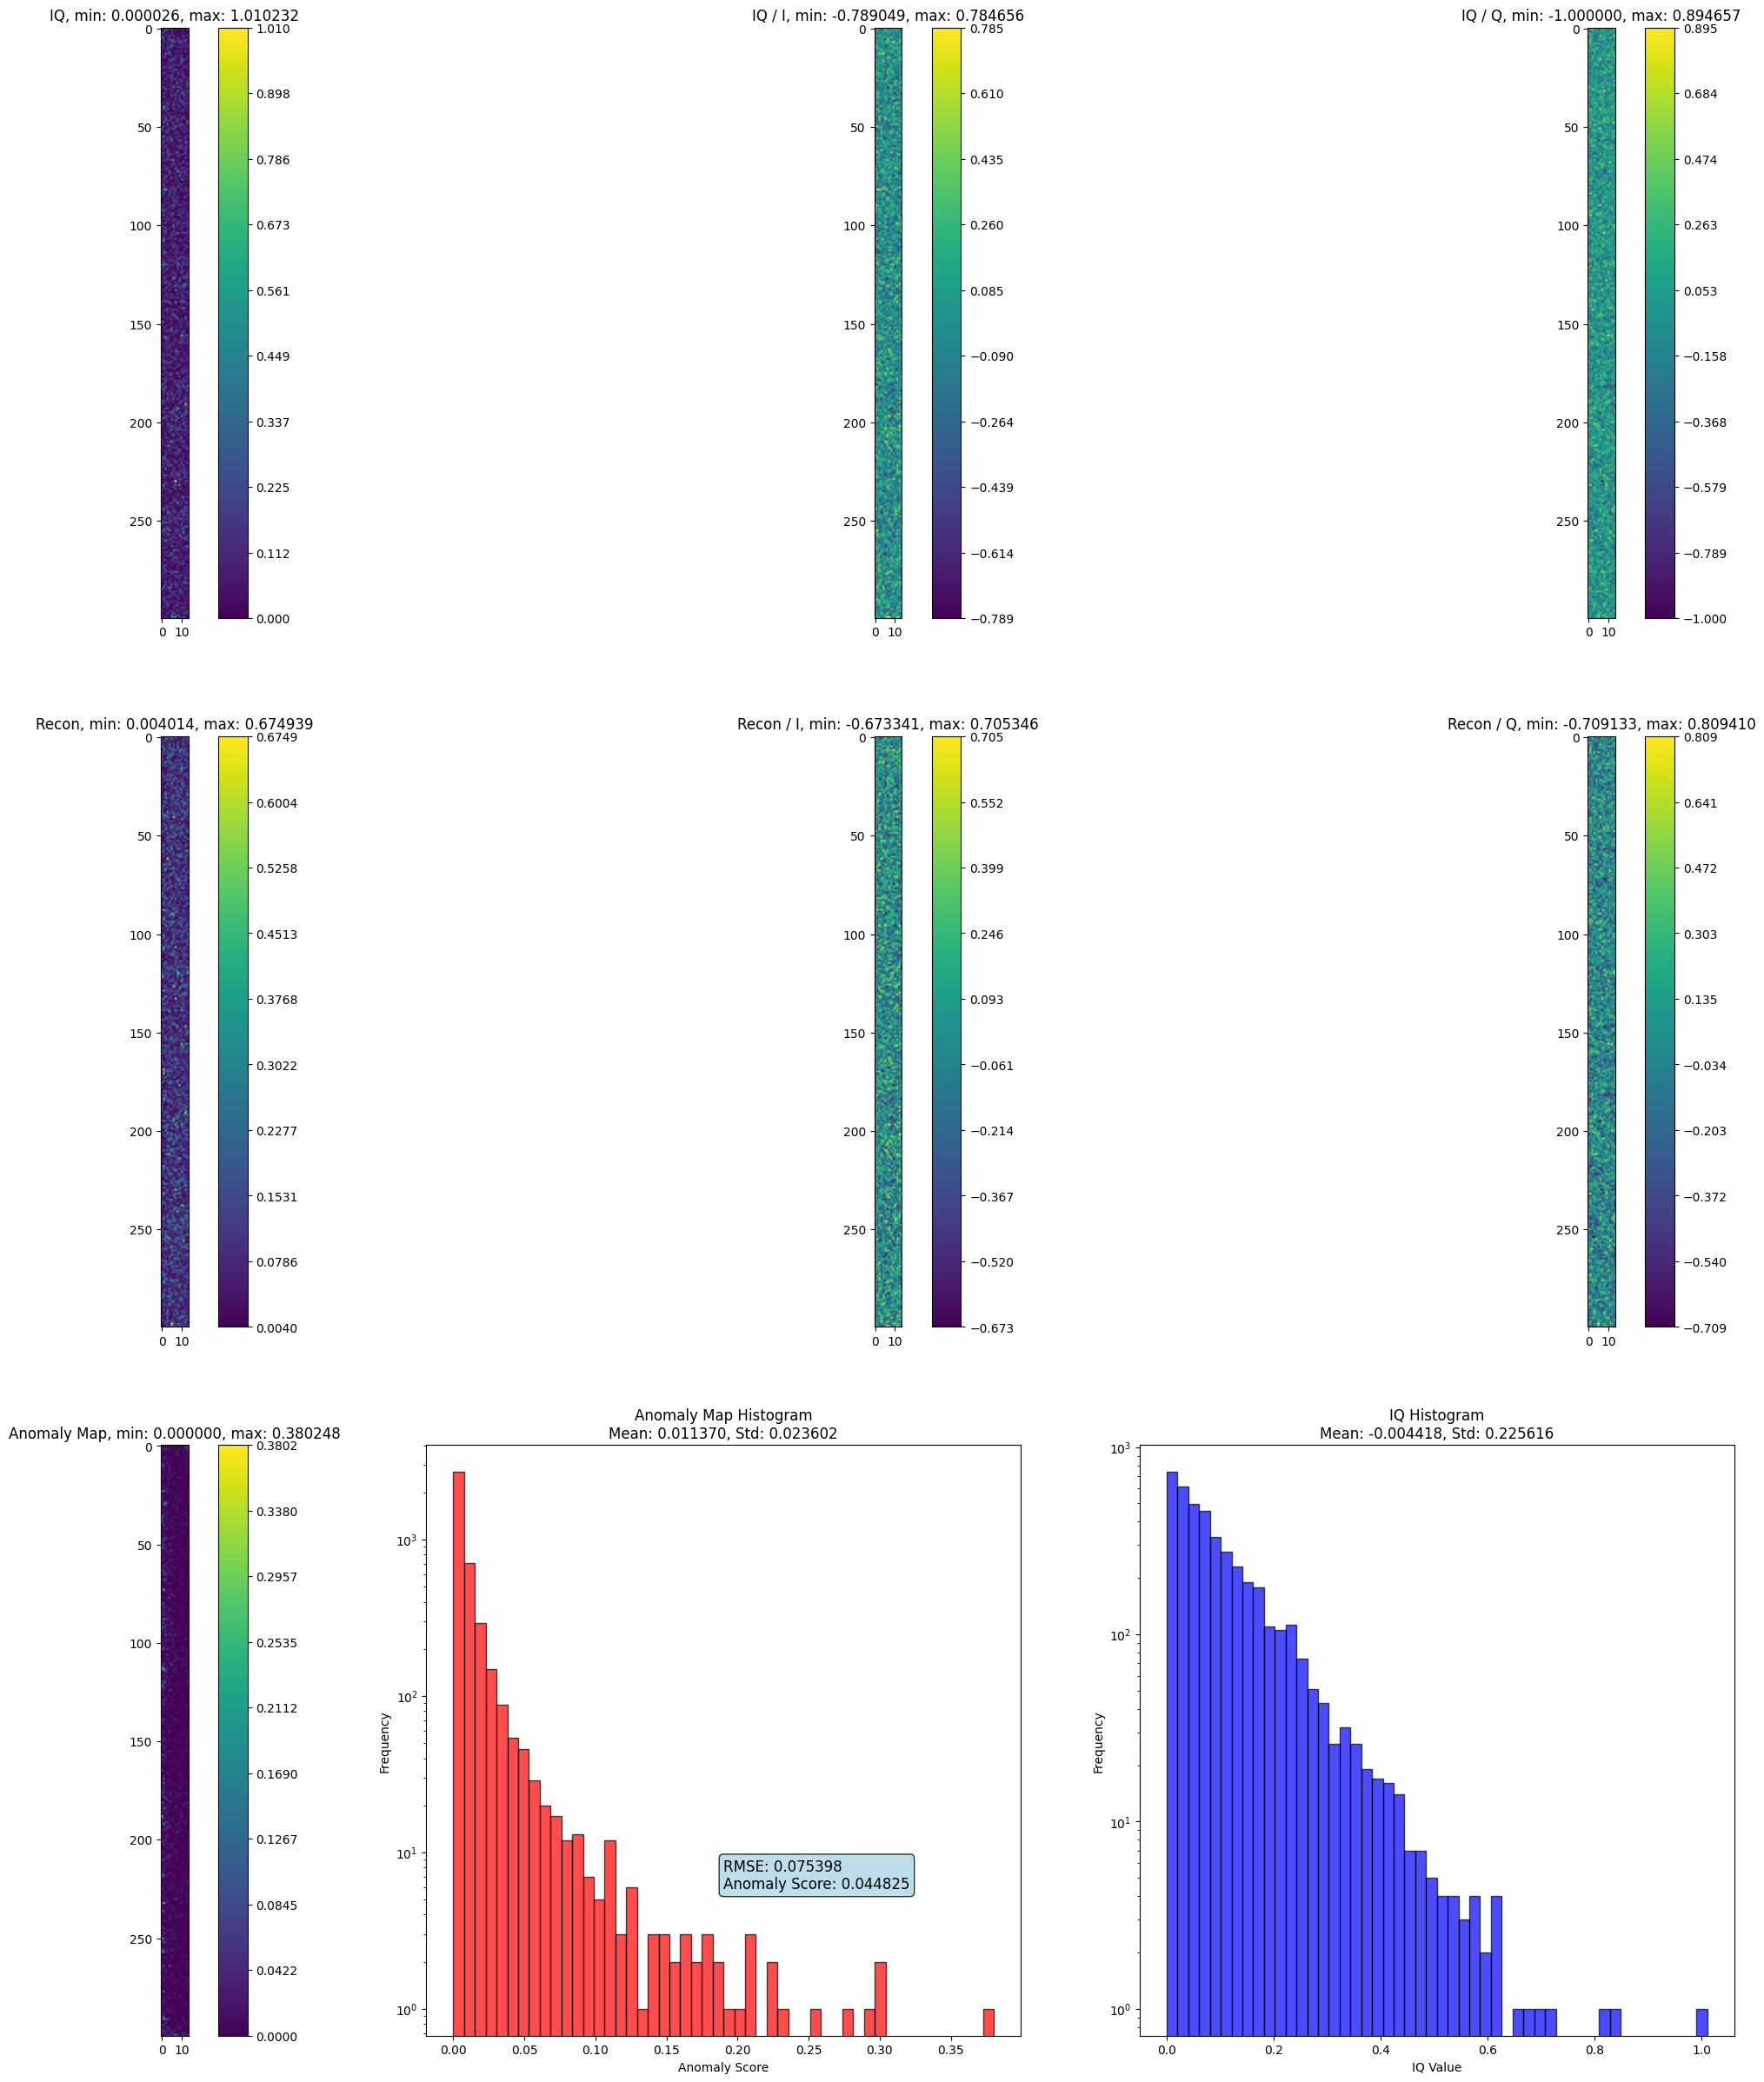

In [17]:
# Load and visualize a test sample
test_file_path = train_df.iloc[1]["file_path"]
test_AE(test_file_path, ae, device)

Test data shape: (300, 14, 3)
Normalized data shape: (2, 300, 14)
Tensor shape: torch.Size([1, 2, 300, 14])
Reconstruction MSE: 0.007842
Original shape: torch.Size([1, 2, 300, 14])
Reconstructed shape: torch.Size([1, 2, 300, 14])
Recon min: -0.807030
Recon max: 0.754058
anomaly_map.shape: (300, 14)


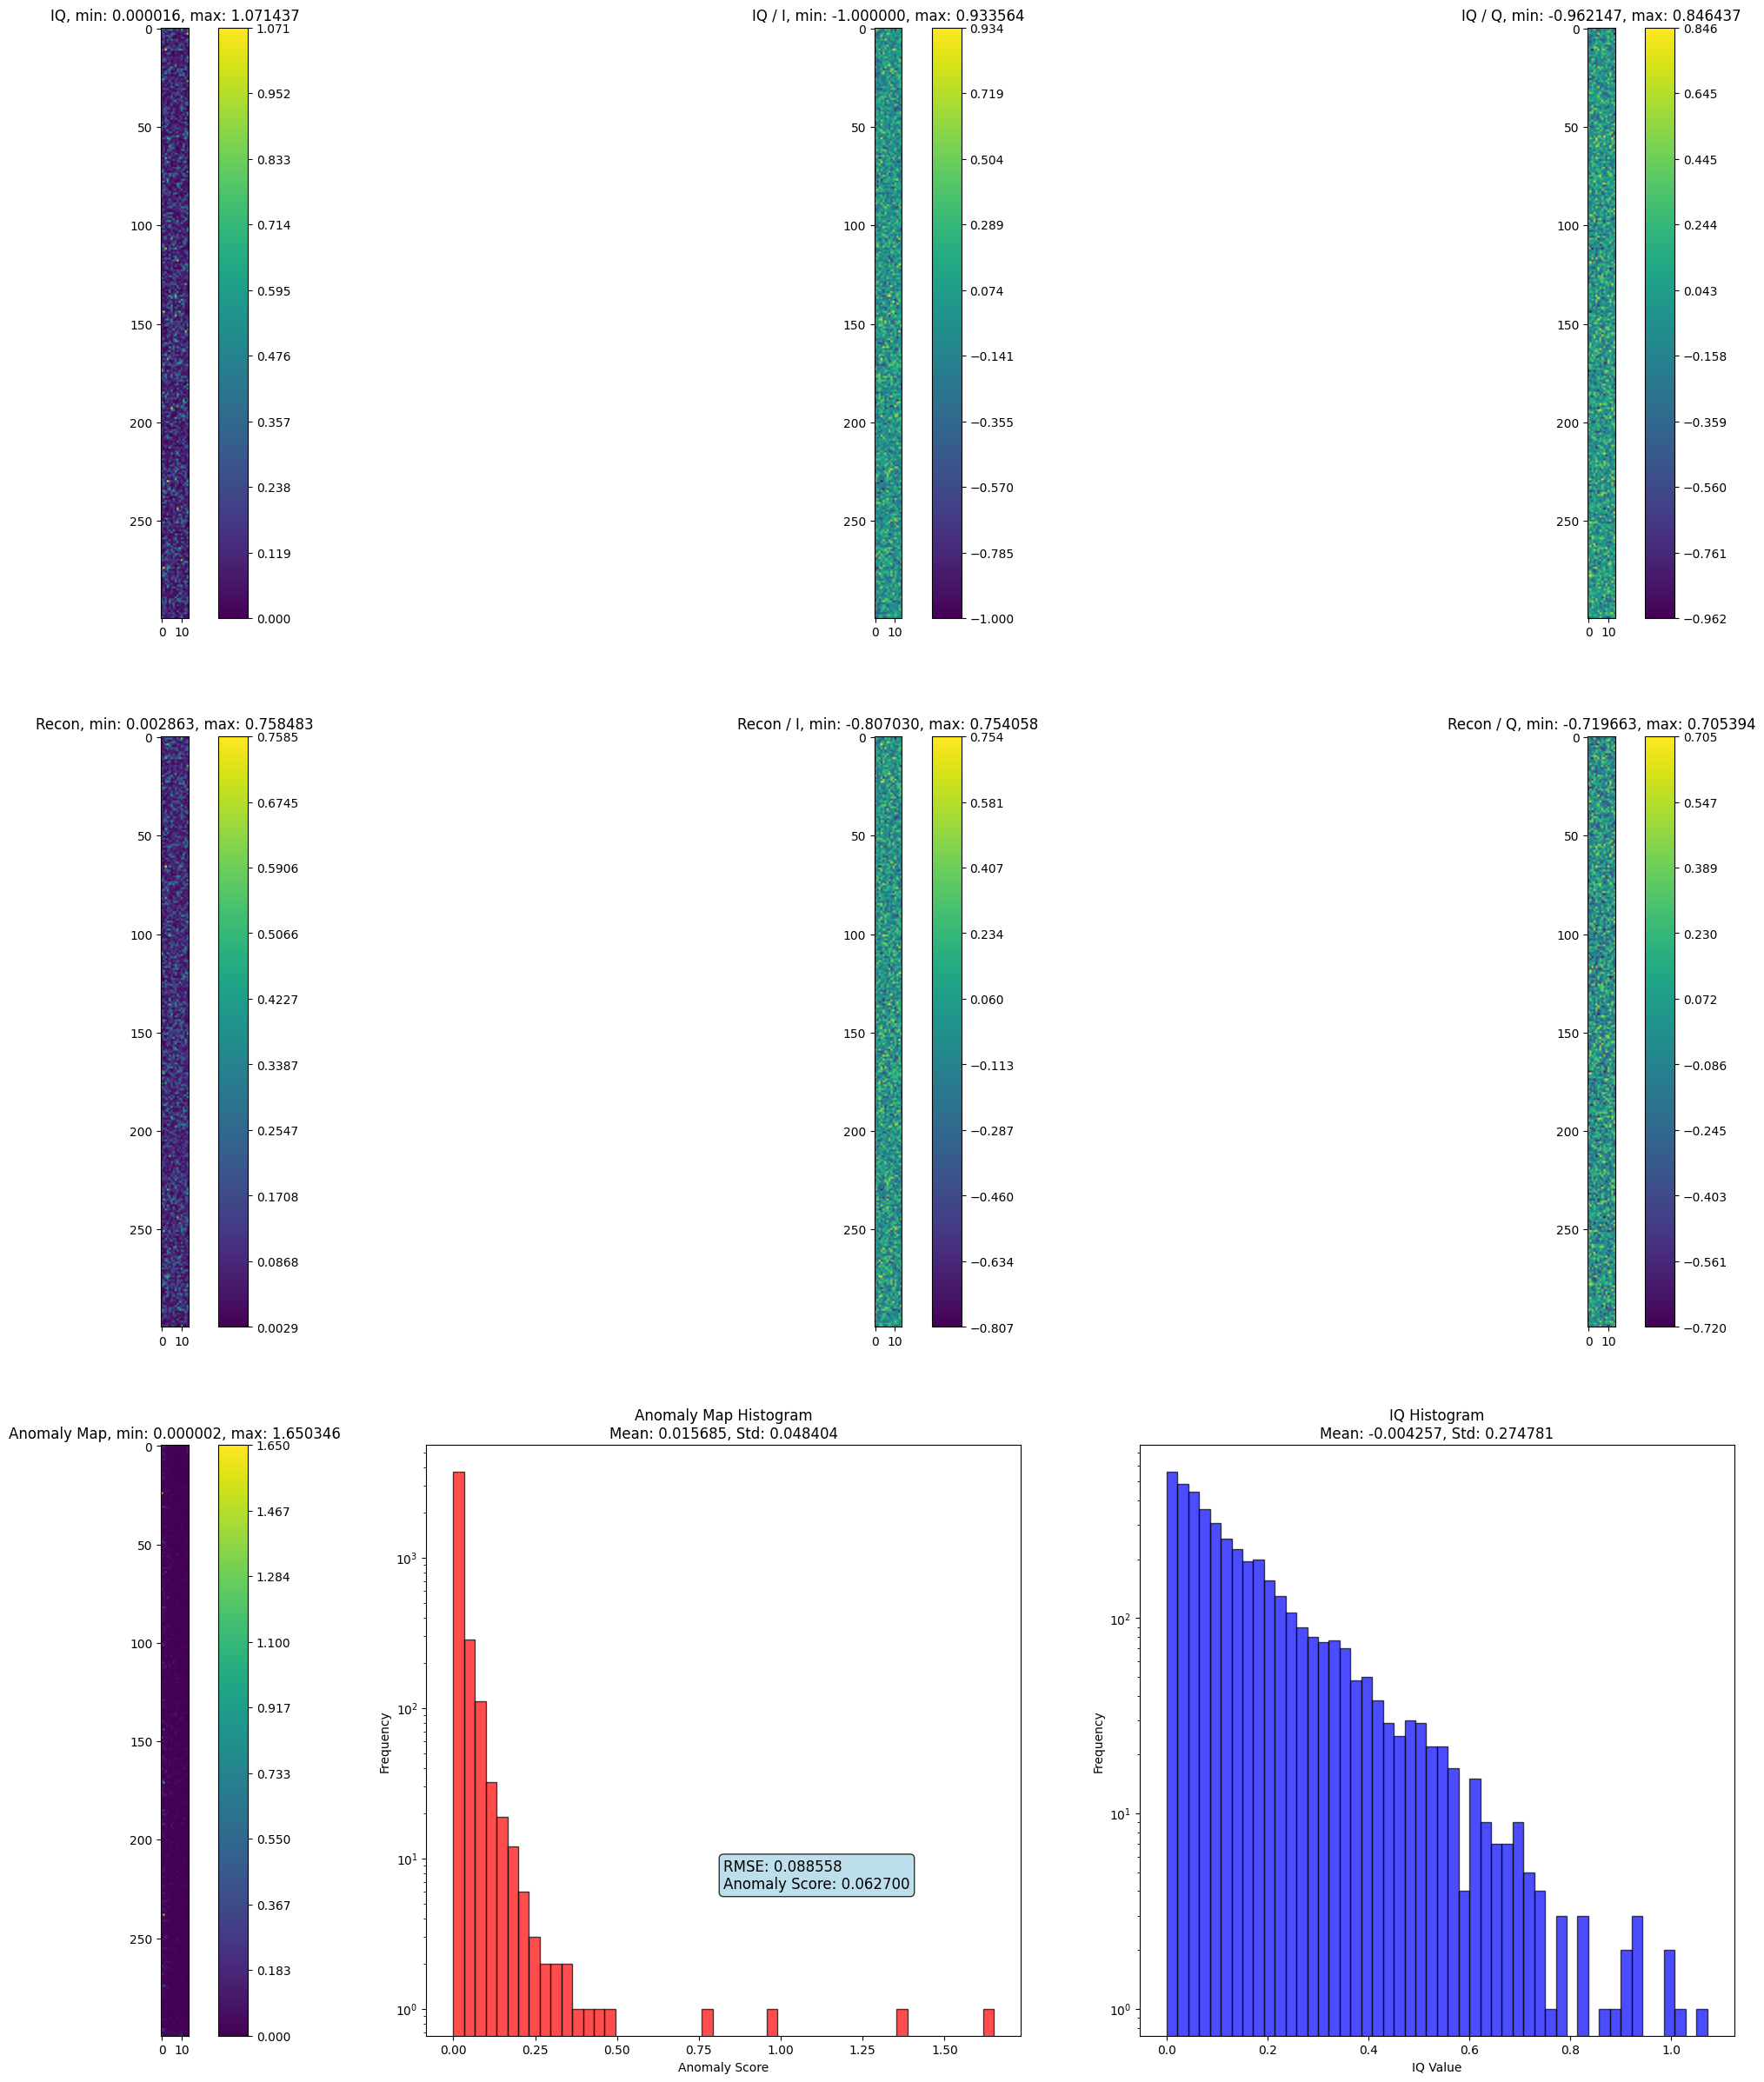

In [18]:
# Load and visualize a test sample
test_file_path = "/home/vantuan_ngo/anomalib-example/datasets/FccIQ/synthetic/train/good/SNR_2_MCS_1_Slot_36_GridIdx_36_NoiseInterferenceGrid.mat"
test_AE(test_file_path, ae, device)

Test data shape: (300, 14, 3)
Normalized data shape: (2, 300, 14)
Tensor shape: torch.Size([1, 2, 300, 14])
Reconstruction MSE: 0.049788
Original shape: torch.Size([1, 2, 300, 14])
Reconstructed shape: torch.Size([1, 2, 300, 14])
Recon min: -0.772779
Recon max: 0.919259
anomaly_map.shape: (300, 14)


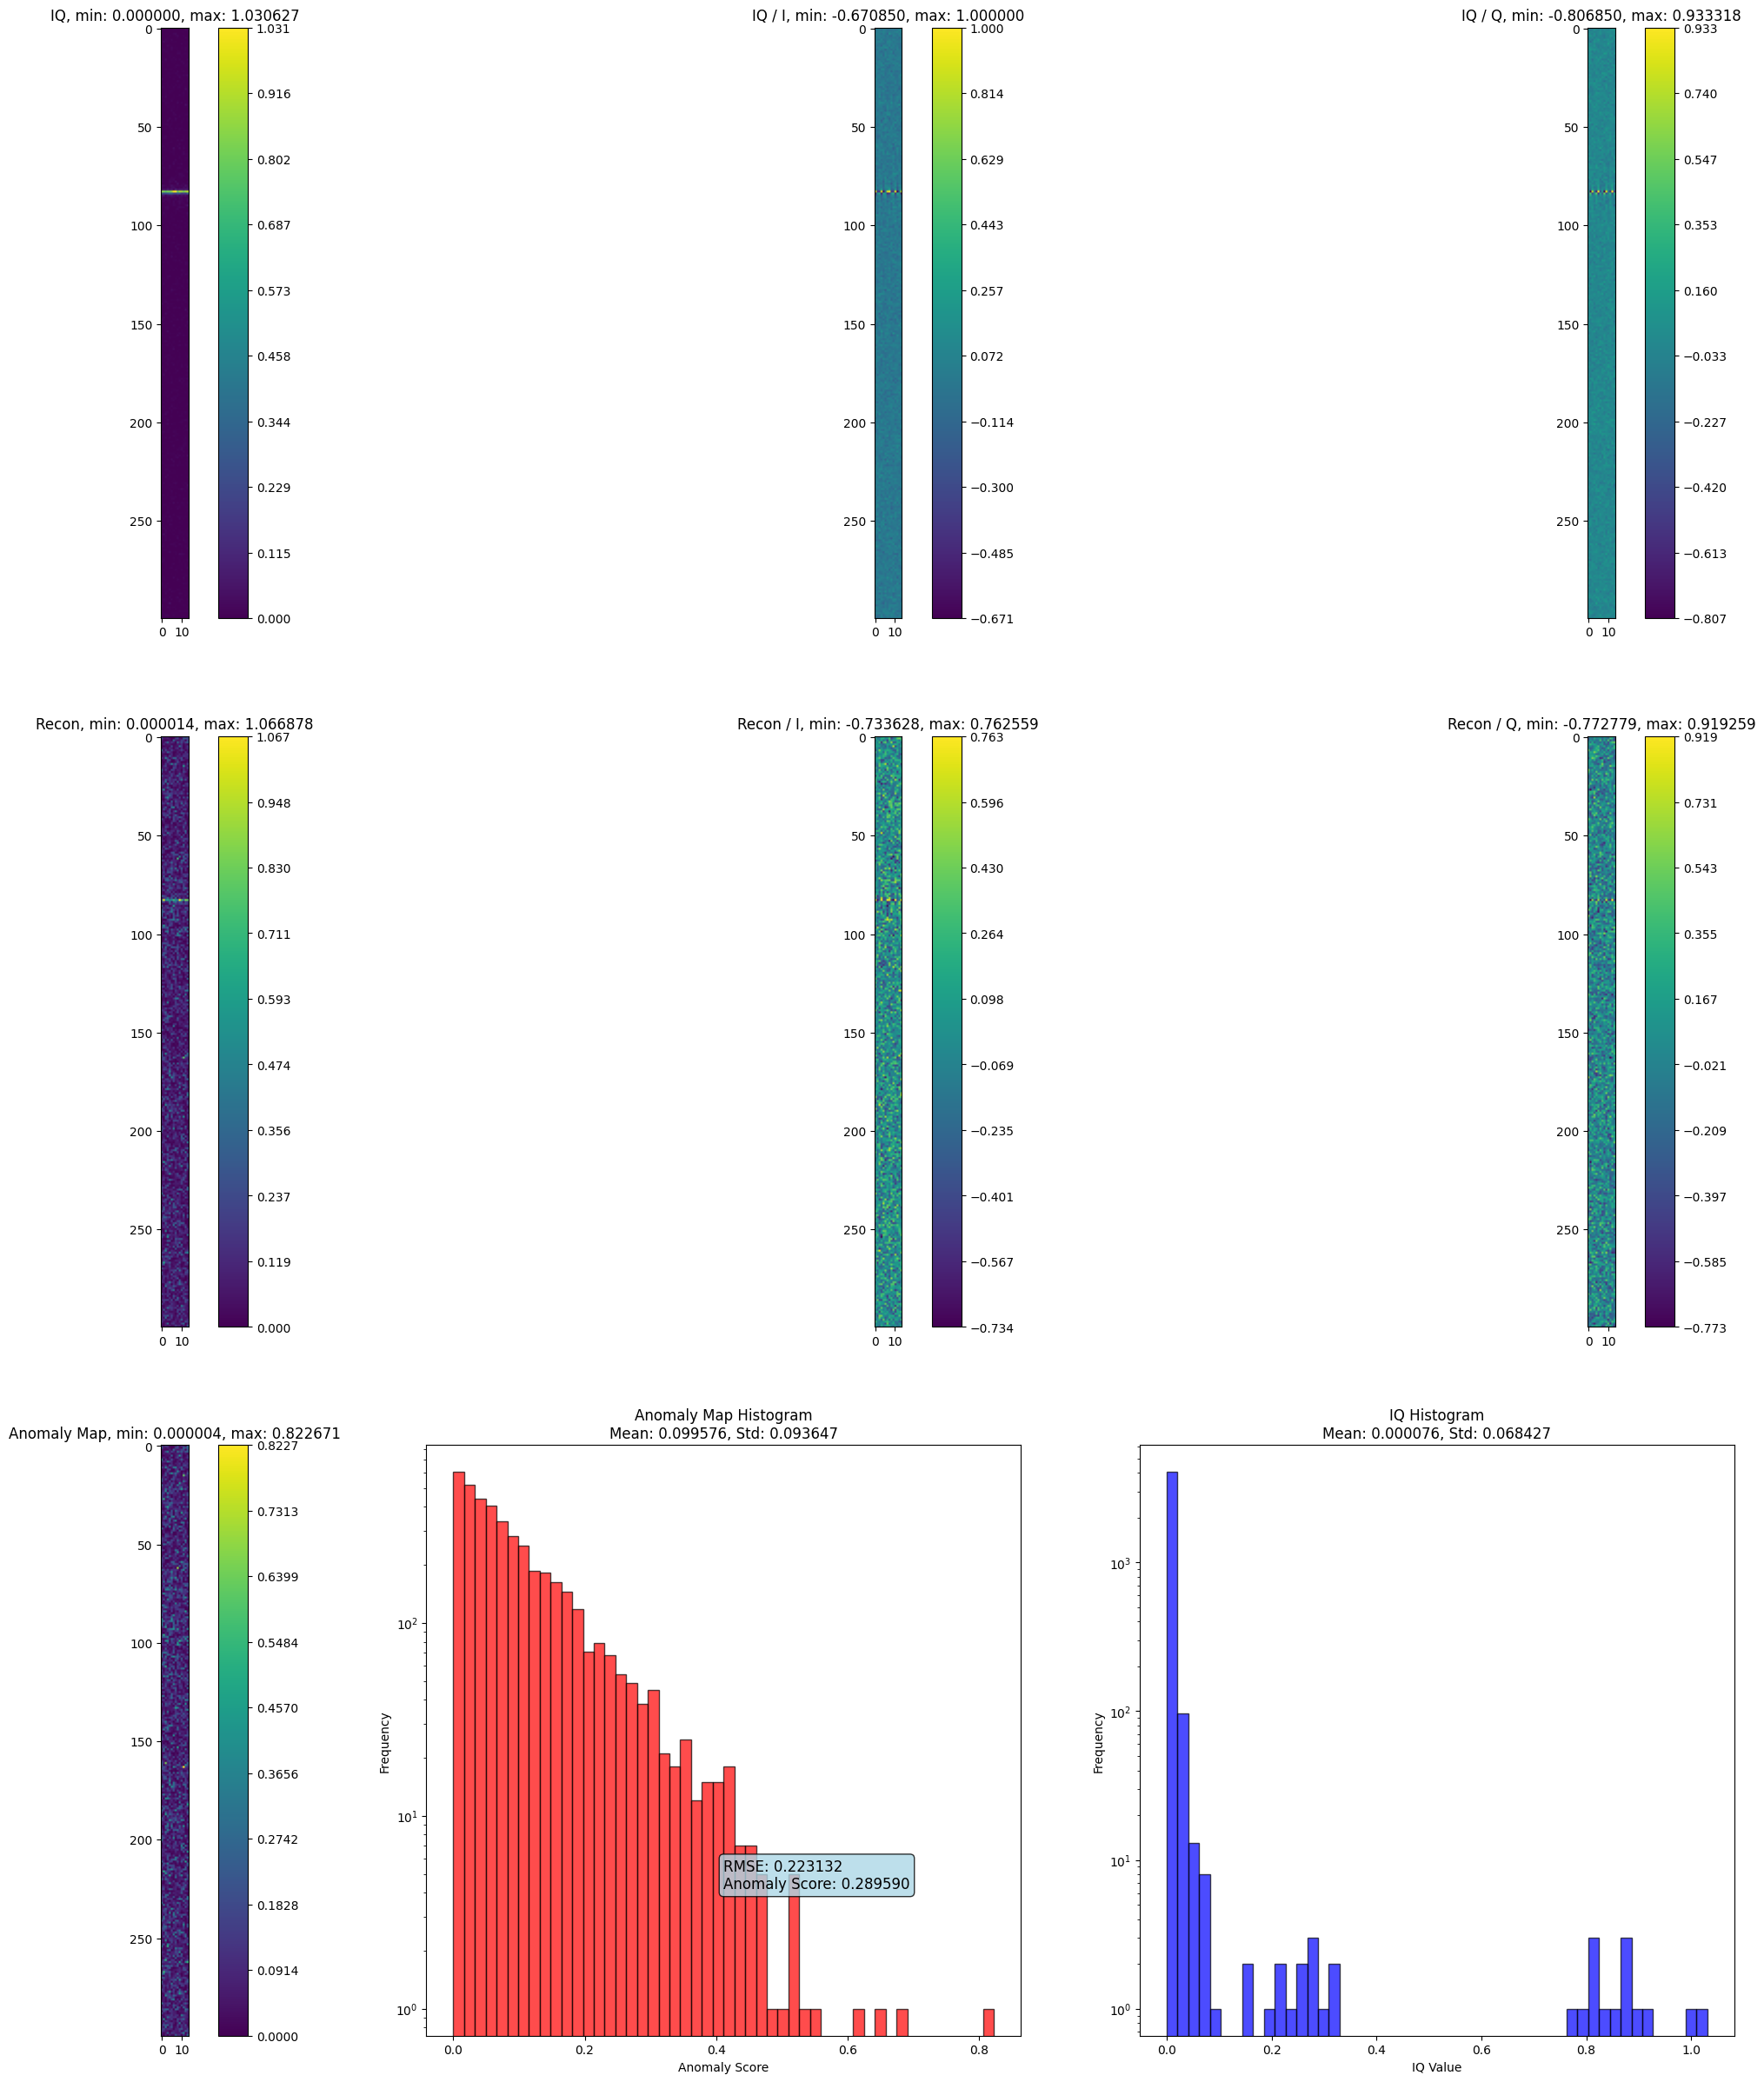

In [19]:
# Load and visualize a test sample
test_file_path = "/home/vantuan_ngo/anomalib-example/datasets/FccIQ/synthetic/test/singletone/SNR_002_SIR_002_MCS_002_FRQ_-01000000_Slot_002_NoiseInterferenceGrid.mat"
test_AE(test_file_path, ae, device)

Test data shape: (300, 14, 3)
Normalized data shape: (2, 300, 14)
Tensor shape: torch.Size([1, 2, 300, 14])
Reconstruction MSE: 0.067105
Original shape: torch.Size([1, 2, 300, 14])
Reconstructed shape: torch.Size([1, 2, 300, 14])
Recon min: -0.740094
Recon max: 0.693119
anomaly_map.shape: (300, 14)


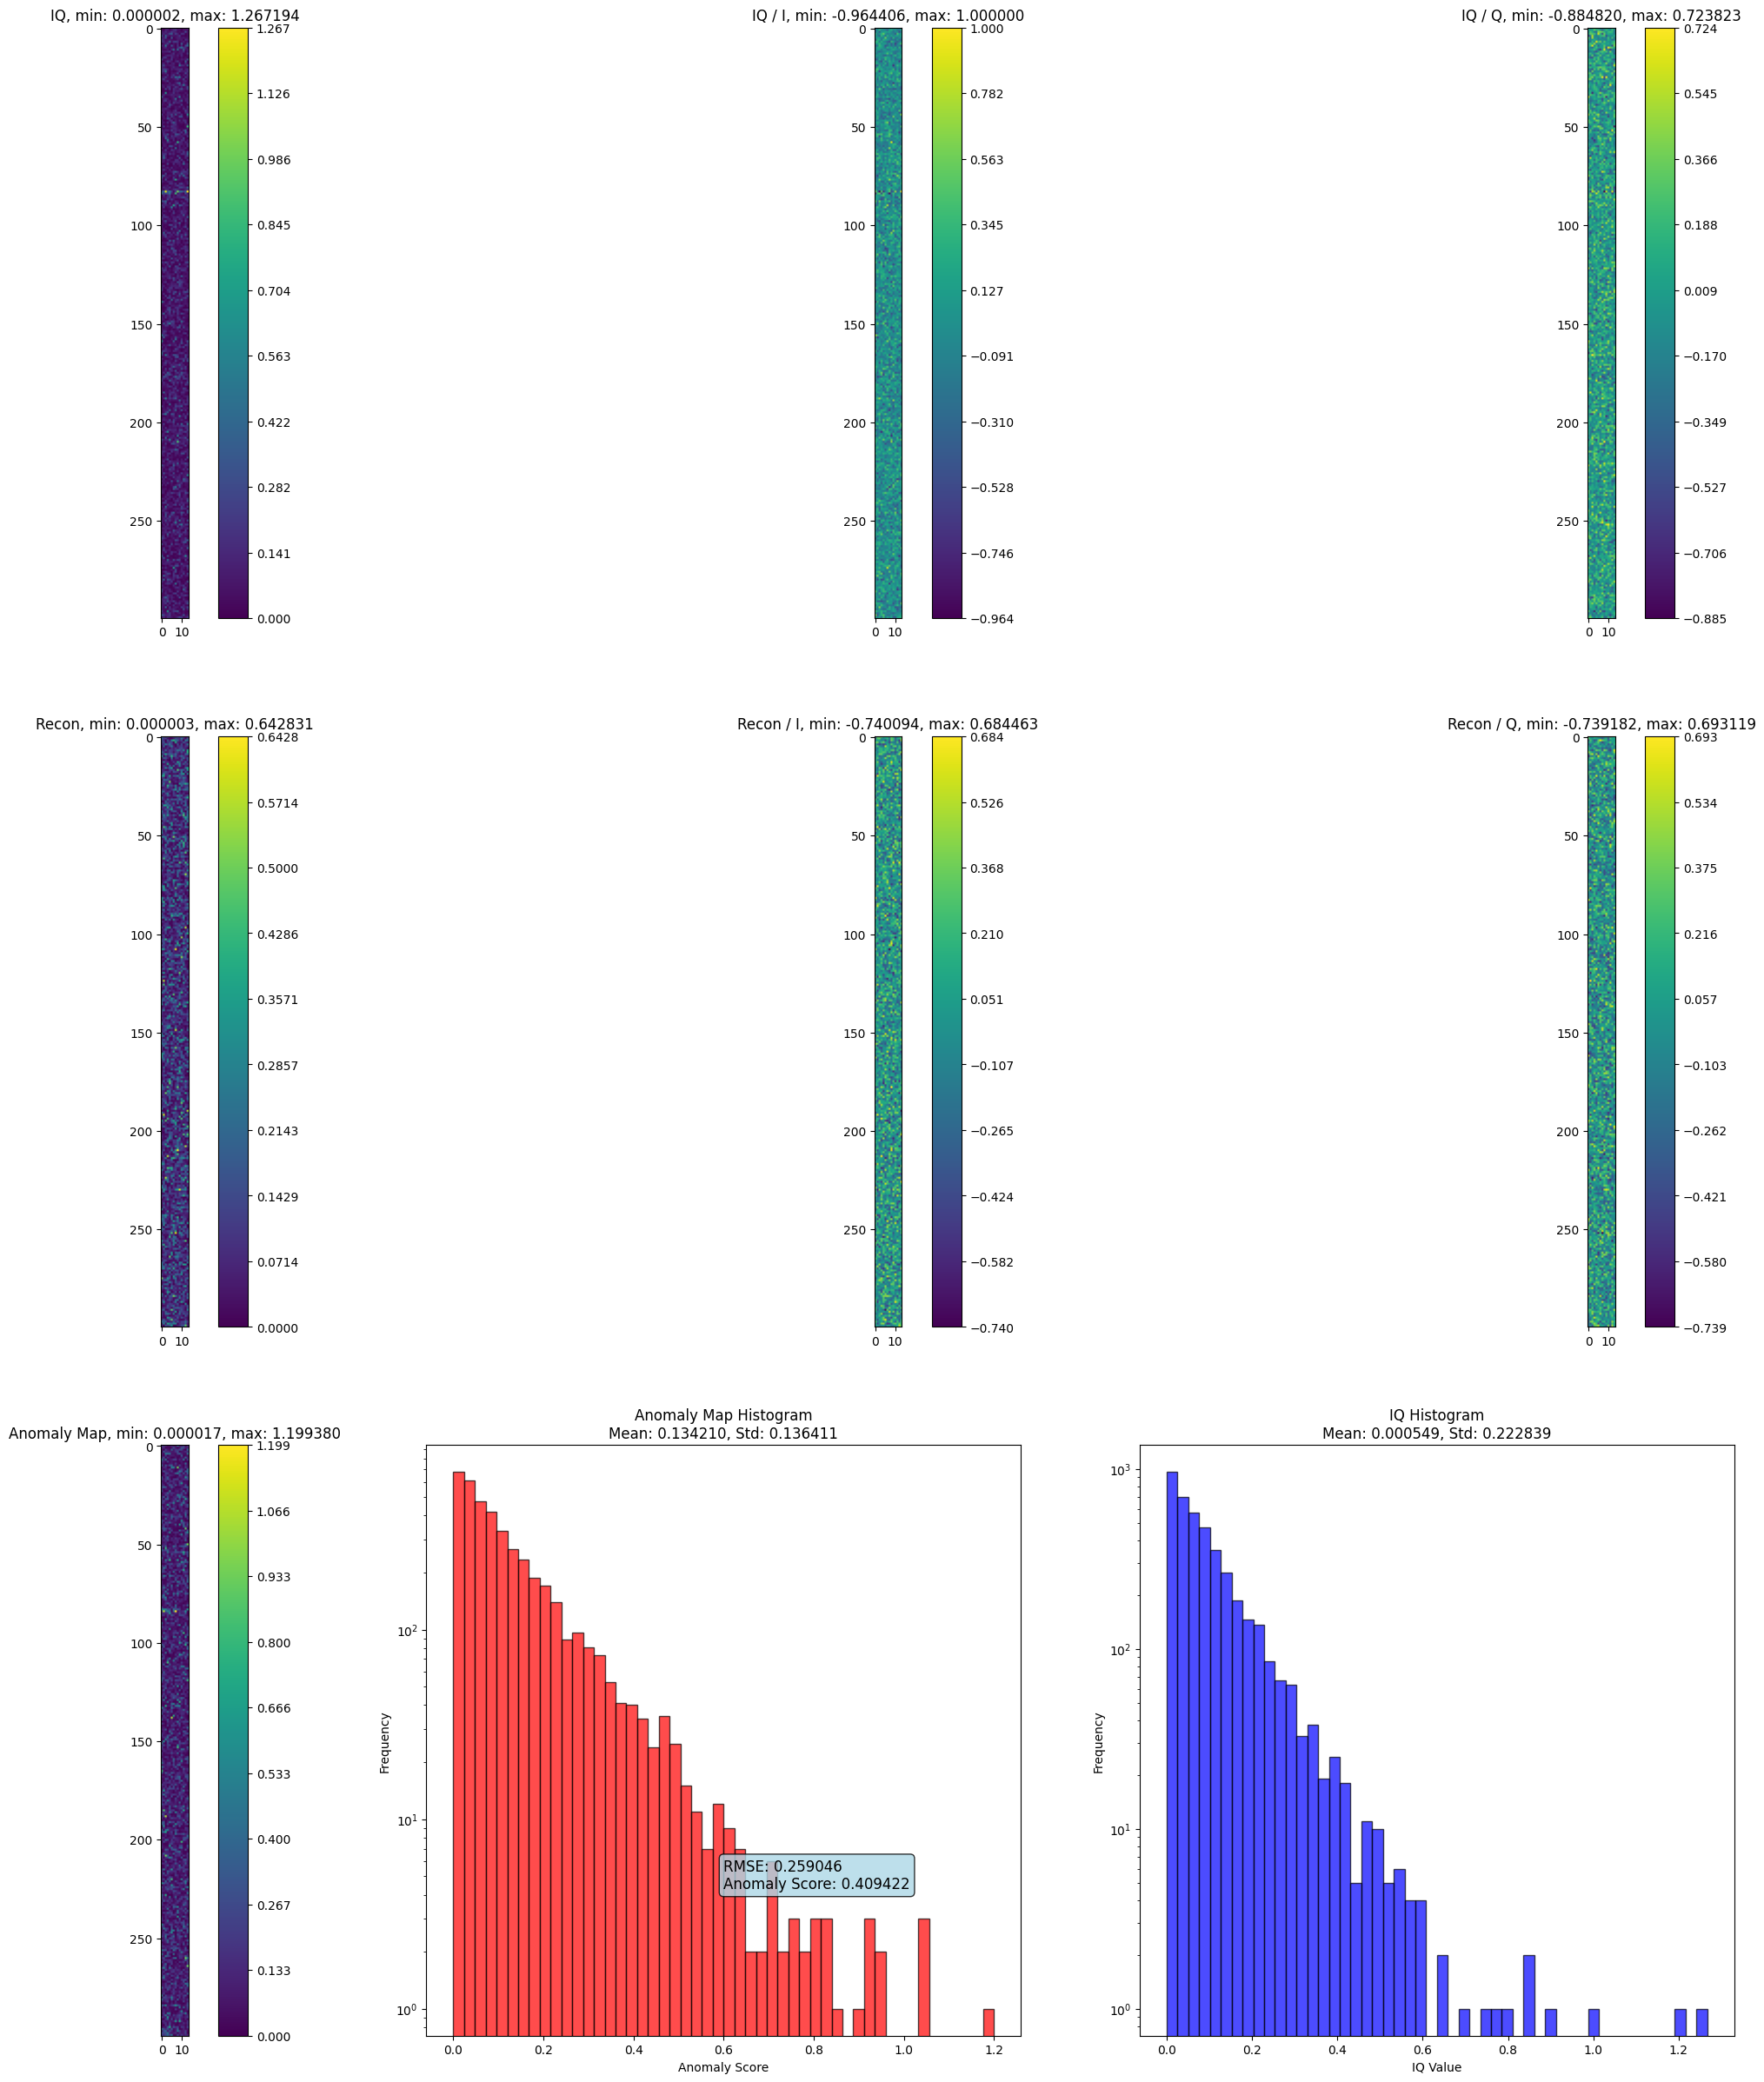

In [15]:
# Load and visualize a test sample
test_file_path = "/home/vantuan_ngo/anomalib-example/datasets/FccIQ/synthetic/test/singletone/SNR_002_SIR_018_MCS_008_FRQ_-01000000_Slot_002_NoiseInterferenceGrid.mat"
test_AE(test_file_path, ae, device)

In [ ]:
import os
import pandas as pd
TEST_DF_FILE_PATH = os.path.join("../datasets/FccIQ/synthetic/test_df.csv")
print("TEST_DF_FILE_PATH: ", TEST_DF_FILE_PATH)
test_df = pd.read_csv(TEST_DF_FILE_PATH)
print(f'test_df.shape: {test_df.shape}')
print(train_df.head())

# train_df = train_df[train_df["SNR"] <= 20]
# train_df = train_df.sample(n=10, random_state=42)

tests, ground_truths = load_test_dataset(train_df)
print(f'tests.shape: {tests.shape}')
print(f'ground_truths.shape: {ground_truths.shape}')

In [ ]:
from sklearn.metrics import f1_score

# Test Autoencoder
print("Testing Autoencoder...")

# Test reconstruction on all test data
with torch.no_grad():

    total_anomaly_loss = 0
    total_samples = 0
    total_f1 = 0
    
    print("Testing reconstruction on all test data...")
    
    for batch_idx, (test_batch, label_batch) in enumerate(test_loader):
        # Move to device
        test_batch = test_batch.to(device)
        label_batch = label_batch.to(device)

        # Forward pass
        reconstructed, mu, logvar = ae(test_batch)
        anomaly_map = generate_anomaly_map(test_batch, reconstructed)
        # print(anomaly_map.shape)
        # print(label_batch.shape)

        # Calculate reconstruction loss
        anomaly_loss = torch.nn.functional.mse_loss(anomaly_map, label_batch)
        total_anomaly_loss += anomaly_loss.item() * test_batch.size(0)
        total_samples += test_batch.size(0)
        
        # Calculate F1 score
        # Convert predictions to binary (threshold at 0.5)
        anomaly_map = anomaly_map.detach().cpu().numpy()
        print(anomaly_map.shape)
        dynamic_threshold = np.percentile(anomaly_map, 99, axis=(2, 3)).squeeze()
        print(dynamic_threshold.shape)
        anomaly_threshold = np.max([[threshold]*anomaly_map.shape[0], dynamic_threshold], axis=0).reshape(anomaly_map.shape[0], 1, 1, 1)
        print(anomaly_threshold.shape)
        # print(f"Anomaly threshold: {anomaly_threshold}")
        anomaly_bin = (anomaly_map > anomaly_threshold)

        label_batch = label_batch.detach().cpu().numpy()
        print(label_batch.shape)
        label_bin = (label_batch > 10*label_batch.mean())
        print("label_bin.shape ", label_bin.shape)
        print("anomaly_bin.shape ", anomaly_bin.shape)
        f1 = f1_score(label_bin.flatten(), anomaly_bin.flatten())
        print("f1 ", f1)
        total_f1 += f1 * test_batch.size(0)

        if batch_idx == 0:
            print(f"First batch - Original shape: {test_batch.shape}")
            print(f"First batch - Reconstructed shape: {reconstructed.shape}")
            print(f"First batch - Latent space shape: mu={mu.shape}, logvar={logvar.shape}")
            print(f"First batch - Reconstruction Loss: {anomaly_loss.item():.6f}")

        if (batch_idx + 1) % 10 == 0:
            print(f"Processed {batch_idx + 1} batches...")
    
    avg_anomaly_loss = total_anomaly_loss / total_samples
    avg_f1 = total_f1 / total_samples
    print(f"\nTesting completed!")
    print(f"Total samples tested: {total_samples}")
    print(f"Average Anomaly Loss: {avg_anomaly_loss:.6f}")
    print(f"Average F1 score: {avg_f1:.6f}")

print("Autoencoder testing completed!")


In [ ]:
from sklearn.metrics import f1_score

# Test Autoencoder
print("Testing Autoencoder...")

# Test reconstruction on all test data
with torch.no_grad():

    total_anomaly_loss = 0
    total_samples = 0
    total_f1 = 0
    
    print("Testing reconstruction on all test data...")
    
    for batch_idx, (test_batch, label_batch) in enumerate(test_loader):
        # Move to device
        test_batch = test_batch.to(device)
        label_batch = label_batch.to(device)

        # Forward pass
        reconstructed, mu, logvar = ae(test_batch)
        anomaly_map = generate_anomaly_map(test_batch, reconstructed)

        # Calculate reconstruction loss
        anomaly_loss = torch.nn.functional.mse_loss(anomaly_map, label_batch)
        total_anomaly_loss += anomaly_loss.item() * test_batch.size(0)
        total_samples += test_batch.size(0)
        
        # Calculate F1 score
        # Convert predictions to binary (threshold at 0.5)
        anomaly_map = anomaly_map.detach().cpu().numpy()
        dynamic_threshold = np.percentile(anomaly_map, 99, axis=(2, 3)).squeeze()
        anomaly_threshold = np.max([[threshold]*anomaly_map.shape[0], dynamic_threshold], axis=0).reshape(anomaly_map.shape[0], 1, 1, 1)
        anomaly_bin = (anomaly_map > anomaly_threshold)
        label_batch = label_batch.detach().cpu().numpy()
        label_bin = (label_batch > 20*label_batch.mean())
        f1 = f1_score(label_bin.flatten(), anomaly_bin.flatten())
        total_f1 += f1 * test_batch.size(0)

        if batch_idx == 0:
            print(f"First batch - Original shape: {test_batch.shape}")
            print(f"First batch - Reconstructed shape: {reconstructed.shape}")
            print(f"First batch - Latent space shape: mu={mu.shape}, logvar={logvar.shape}")
            print(f"First batch - Reconstruction Loss: {anomaly_loss.item():.6f}")
        
        if (batch_idx + 1) % 20 == 0:
            print(f"Processed {batch_idx + 1} batches...")
            print("f1 ", f1)
            
            plt.figure(figsize=(24, 8))
            plt.subplot(1,6,1)
            plt.imshow(test_batch[0].cpu().numpy()[0], cmap='viridis')
            print("test_batch[0].shape", test_batch[0].shape)
            plt.title('Original Input')
            plt.xlabel('X')
            plt.ylabel('Y')
            plt.colorbar()
            
            plt.subplot(1,6,2)
            plt.imshow(anomaly_map[0][0], cmap='viridis')
            print("anomaly_map[0].shape", anomaly_map[0].shape)
            plt.title('Anomaly Map')
            plt.xlabel('X')
            plt.ylabel('Y')
            plt.colorbar()
            
            plt.subplot(1,6,3)
            plt.imshow(label_batch[0][0], cmap='viridis')
            print("label_batch[0].shape", label_batch[0].shape)
            plt.title('Label Map')
            plt.xlabel('X')
            plt.ylabel('Y')
            plt.colorbar()

            plt.subplot(1,6,4)
            plt.imshow(anomaly_bin[0][0], cmap='viridis')
            plt.title('AB')
            print("anomaly_bin[0].shape", anomaly_bin[0].shape)
            plt.xlabel('X')
            plt.ylabel('Y')
            plt.colorbar()
            
            plt.subplot(1,6,5)
            plt.imshow(label_bin[0][0], cmap='viridis')
            plt.title('LB')
            print("label_bin[0].shape", label_bin[0].shape)
            plt.xlabel('X')
            plt.ylabel('Y')
            plt.colorbar()
            
            plt.subplot(1,6,6)
            diff_bin = (anomaly_bin[0][0] ^ label_bin[0][0])
            plt.imshow(diff_bin, cmap='gray')
            plt.title('AB ^ LB')
            plt.xlabel('X')
            plt.ylabel('Y')
            plt.colorbar()

            # plt.tight_layout()

            plt.show()
            break
    
    avg_anomaly_loss = total_anomaly_loss / total_samples
    avg_f1 = total_f1 / total_samples
    print(f"\nTesting completed!")
    print(f"Total samples tested: {total_samples}")
    print(f"Average Anomaly Loss: {avg_anomaly_loss:.6f}")
    print(f"Average F1 score: {avg_f1:.6f}")

print("Autoencoder testing completed!")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from reportlab.lib.pagesizes import letter
from reportlab.platypus import SimpleDocTemplate, Image
from io import BytesIO

# Initialize PDF
pdf_filename = "anomaly_maps.pdf"
pdf = SimpleDocTemplate(pdf_filename, pagesize=letter)
elements = []

for batch_idx, iqs in enumerate(train_loader):
    print(f"Processing batch {batch_idx}/{len(train_loader)}")
    print(iqs.shape)
    iqs = iqs.to(device)
    
    with torch.no_grad():
        recons, mu, logvar = ae(iqs)
        anomaly_maps = generate_anomaly_map(iqs, recons)
        
        print("Saving to file...")
        iqs = iqs.cpu().numpy()
        for i in range(iqs.shape[0]):
            iq = iqs[i]
            recon = recons[i].cpu().numpy()
            anomaly_map = anomaly_maps[i].cpu().numpy().squeeze()
            # print("iq.shape: ", iq.shape)
            # print("recon.shape: ", recon.shape)
            # print("anomaly_map.shape: ", anomaly_map.shape)
            
            # Create figure
            plt.figure(figsize=(10, 10))
            plt.subplot(1, 3, 1)
            plt.imshow(np.sum(iq**2, axis=0), cmap='viridis')
            plt.colorbar()
            plt.title('IQ')
            
            plt.subplot(1, 3, 2)
            plt.imshow(np.sum(recon**2, axis=0), cmap='viridis')
            plt.colorbar()
            plt.title('Recon')
            
            plt.subplot(1, 3, 3)
            plt.imshow(anomaly_map, cmap='gray')
            plt.colorbar()
            plt.title('Anomaly Map')
            
            # Save plot to BytesIO buffer
            bio = BytesIO()
            plt.savefig(bio, format='png', bbox_inches='tight')
            bio.seek(0)
            
            # Add to PDF
            plot_image = Image(bio, width=300, height=300)
            elements.append(plot_image)
            
            plt.close()
    #         break
    #     break
    # break

print("Building PDF")
pdf.build(elements)
print(f"Saved anomaly plots to ./{pdf_filename}")